### Read News Dataset & Text Cleaning

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

train_data = pd.read_csv('../input/news-headline/train.csv', names=['news','sentiment'], header=None)
val_data = pd.read_csv('../input/news-headline/validation.csv', names=['news','sentiment'], header=None)
test_data = pd.read_csv('../input/news-headline/test.csv', names=['news','sentiment'], header=None)

stop_words = set(stopwords.words('english'))
stop_words -= {
    "don", "hadn't", "hasn", "didn't", "aren't", "needn't", "couldn't", 
    "haven", "down", "weren't", "weren", "doesn", "couldn", "don't", 
    "mightn't", "hasn't", "off", "wasn", "mustn", "hadn", "didn", "up",
    "shan't", "isn", "mightn", "mustn't", "shouldn't", "doesn't", "no", 
    "not", "haven't", "wouldn", "won't", "wouldn't", "shouldn", "aren", 
    "isn't", "wasn't", "ain", "under", "needn", "shan", "above"
}

def clean_text(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    
    translator = str.maketrans('', '', string.punctuation)
    words = [w.translate(translator) for w in words]
    
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)
    
train_data['news'] = train_data['news'].apply(clean_text)
val_data['news'] = val_data['news'].apply(clean_text)
test_data['news'] = test_data['news'].apply(clean_text)

### Map Values of Sentiments to Positive Numbers

In [2]:
# negative: 0, neutral: 1, positive: 2
train_data['sentiment'] += 1
val_data['sentiment'] += 1
test_data['sentiment'] += 1

In [3]:
train_data.head()

,news,sentiment
0,dr interim pm agong accepts resignation,1
1,mmag jets targets annual cargo volume grow fiv...,2
2,civil servants continue provide quality effect...,1
3,klci falls tracks regional decline,0
4,anzo showing signs developing rebound rhb reta...,1


### Read Pretrained Embeddings

In [4]:
import numpy as np

embeddings_index = dict()
embedding_dim = 300

with open('../input/glove42b300dtxt/glove.42B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 1917494 word vectors.


### Initialize Tokenizer

In [5]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['news'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f'Vocabulary Size: {vocab_size} words')

Vocabulary Size: 22898 words


### Create Embedding Matrix for News Dataset

In [6]:
hits = 0
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f'Converted {hits} words ({misses} misses)')

Converted 19560 words (3337 misses)


### Data Preparation

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_sequences = tokenizer.texts_to_sequences(train_data['news'])
avg_words = sum([len(ts) for ts in train_sequences])/len(train_sequences)
max_seq_len = len(max(train_sequences, key=len)) 
train_sequences = pad_sequences(train_sequences, maxlen=max_seq_len, padding='post')    

x_train = train_sequences
y_train = train_data['sentiment'].to_numpy()

print(f'Average words per sentence: {avg_words:.2f} words')
print(f'Maximum words: {max_seq_len}')

Average words per sentence: 7.06 words
Maximum words: 53


In [8]:
val_sequences = tokenizer.texts_to_sequences(val_data['news'])
val_sequences = pad_sequences(val_sequences, maxlen=max_seq_len, padding='post')

x_val = val_sequences
y_val = val_data['sentiment'].to_numpy()

In [9]:
test_sequences = tokenizer.texts_to_sequences(test_data['news'])
test_sequences = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post')

x_test = test_sequences
y_test = test_data['sentiment'].to_numpy()

### Build the Model

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

inputs = keras.Input(shape=(max_seq_len,))
x = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    mask_zero=True,
    trainable=False,
)(inputs)
x = layers.Bidirectional(layers.LSTM(
    8, 
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.1,
))(x)
x = layers.Bidirectional(layers.LSTM(
    4,
    dropout=0.2,
    recurrent_dropout=0.1,
))(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

2022-01-29 08:51:25.683651: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 08:51:25.797501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 08:51:25.798595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 08:51:25.801200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 53, 300)           6869400   
_________________________________________________________________
bidirectional (Bidirectional (None, 53, 16)            19776     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8)                 672       
_________________________________________________________________
dense (Dense)                (None, 3)                 27        
Total params: 6,889,875
Trainable params: 20,475
Non-trainable params: 6,869,400
_________________________________________________________________


###  Visualize the Model

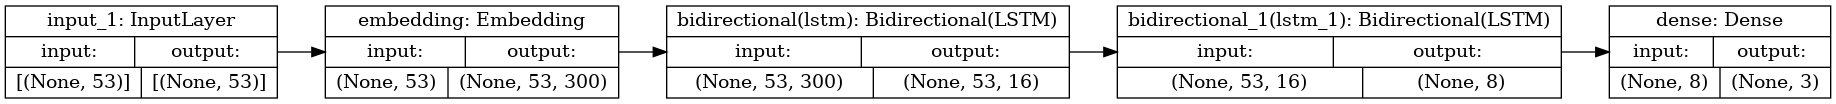

In [11]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, rankdir='LR')

### Configure Callbacks for Plotting Model Performance

In [12]:
from keras.callbacks import Callback

class Histories(Callback):
    
    def on_train_begin(self,logs={}):
        self.accs = []
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.accs.append(logs.get('accuracy'))
        self.losses.append(logs.get('loss'))

histories = Histories()

### Train the Model

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5E-3),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'],
)

batch_size=256
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    batch_size=batch_size,
    epochs=20,
    callbacks=[histories]
)

2022-01-29 08:51:30.781398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
241/241 [==============================] - 409s 2s/step - loss: 0.8312 - accuracy: 0.6157 - val_loss: 0.8579 - val_accuracy: 0.5610
Epoch 2/20
241/241 [==============================] - 398s 2s/step - loss: 0.7300 - accuracy: 0.6808 - val_loss: 0.8837 - val_accuracy: 0.5640
Epoch 3/20
241/241 [==============================] - 399s 2s/step - loss: 0.7007 - accuracy: 0.6987 - val_loss: 0.8816 - val_accuracy: 0.5520
Epoch 4/20
241/241 [==============================] - 399s 2s/step - loss: 0.6827 - accuracy: 0.7106 - val_loss: 0.8554 - val_accuracy: 0.5710
Epoch 5/20
241/241 [==============================] - 400s 2s/step - loss: 0.6704 - accuracy: 0.7172 - val_loss: 0.9100 - val_accuracy: 0.5490
Epoch 6/20
241/241 [==============================] - 404s 2s/step - loss: 0.6593 - accuracy: 0.7226 - val_loss: 0.8698 - val_accuracy: 0.5780
Epoch 7/20
241/241 [==============================] - 400s 2s/step - loss: 0.6526 - accuracy: 0.7238 - val_loss: 0.9038 - val_accuracy: 0.5510

In [14]:
train_accuracy = history.history['accuracy'][-1] * 100
train_loss = history.history['loss'][-1]
val_accuracy = history.history['val_accuracy'][-1] * 100
val_loss = history.history['val_loss'][-1]

print(f'Training Accuracy: {train_accuracy:.2f}%')
print(f'Traning Loss: {train_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Validation Loss: {val_loss:.4f}')

Training Accuracy: 74.19%
Traning Loss: 0.6153
Validation Accuracy: 56.70%
Validation Loss: 0.9260


### Plot Accuracy and Loss of the Model

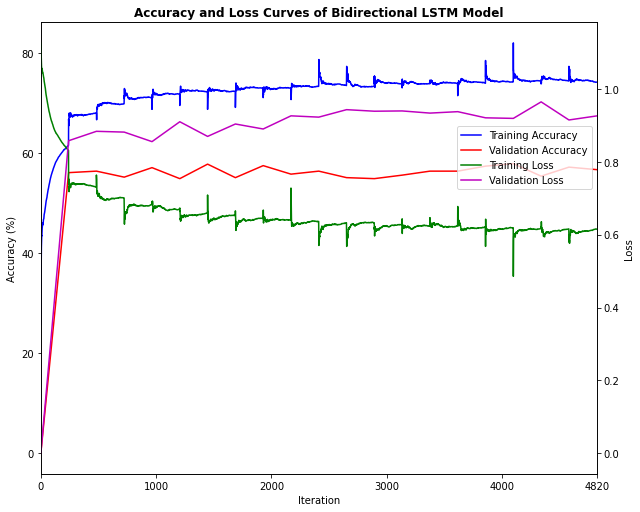

In [15]:
import matplotlib.pyplot as plt

train_accs = [y*100 for y in histories.accs]
train_losses = [y for y in histories.losses]

val_accs = [y*100 for y in history.history['val_accuracy']]
val_accs.insert(0, 0)

val_losses = [y for y in history.history['val_loss']]
val_losses.insert(0, 0)

fig, ax1 = plt.subplots(figsize=(9,7))
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy (%)')

xlim = (0, len(train_accs))
xticks = [xt for xt in range(xlim[0], xlim[1], 1000)]
xticks.append(xlim[1])
ax1.set_xlim(xlim)
ax1.set_xticks(xticks)

x_train = [i for i in range(xlim[0], xlim[1], 1)]
x_val = [i for i in range(xlim[0], xlim[1], round(xlim[1]/20))]
x_val.append(xlim[1])

ax1.plot(x_train, train_accs, 'b', label='Training Accuracy')
ax1.plot(x_val, val_accs, 'r', label='Validation Accuracy')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')

ax2.plot(x_train, train_losses, 'g', label='Training Loss')
ax2.plot(x_val, val_losses, 'm', label='Validation Loss')

fig.tight_layout()
plt.title('Accuracy and Loss Curves of Bidirectional LSTM Model', fontweight='bold')
fig.legend(loc="center right", bbox_to_anchor=(1,0.7), bbox_transform=ax1.transAxes)
plt.savefig('performance.svg')
plt.show()

### Save the Model

In [16]:
model.save('bi_lstm_model.h5')

### Load the Model

In [17]:
# model = keras.models.load_model('./bi_lstm_model.h5')

### Evaluate the Model

In [18]:
test_loss, test_accuracy = model.evaluate(
    x_test,
    y_test,
    batch_size=batch_size,
    verbose=0
)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Loss: {test_loss:.5f}')

Test Accuracy: 60.40%
Test Loss: 0.85360


In [19]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=batch_size, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

sentiments = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred, target_names=sentiments))

4/4 [==============================] - 1s 89ms/step
              precision    recall  f1-score   support

    Negative       0.67      0.65      0.66       256
     Neutral       0.46      0.55      0.50       305
    Positive       0.69      0.62      0.65       439

    accuracy                           0.60      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.62      0.60      0.61      1000



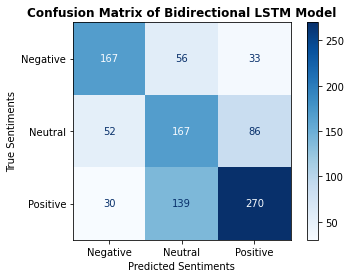

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiments)
cmd.plot(cmap=plt.cm.Blues)
cmd.ax_.set(xlabel='Predicted Sentiments', ylabel='True Sentiments')

plt.title('Confusion Matrix of Bidirectional LSTM Model', fontweight='bold')
plt.savefig('cm.svg')
plt.show()